# DEMO: Data Exploration and Feature Engineering

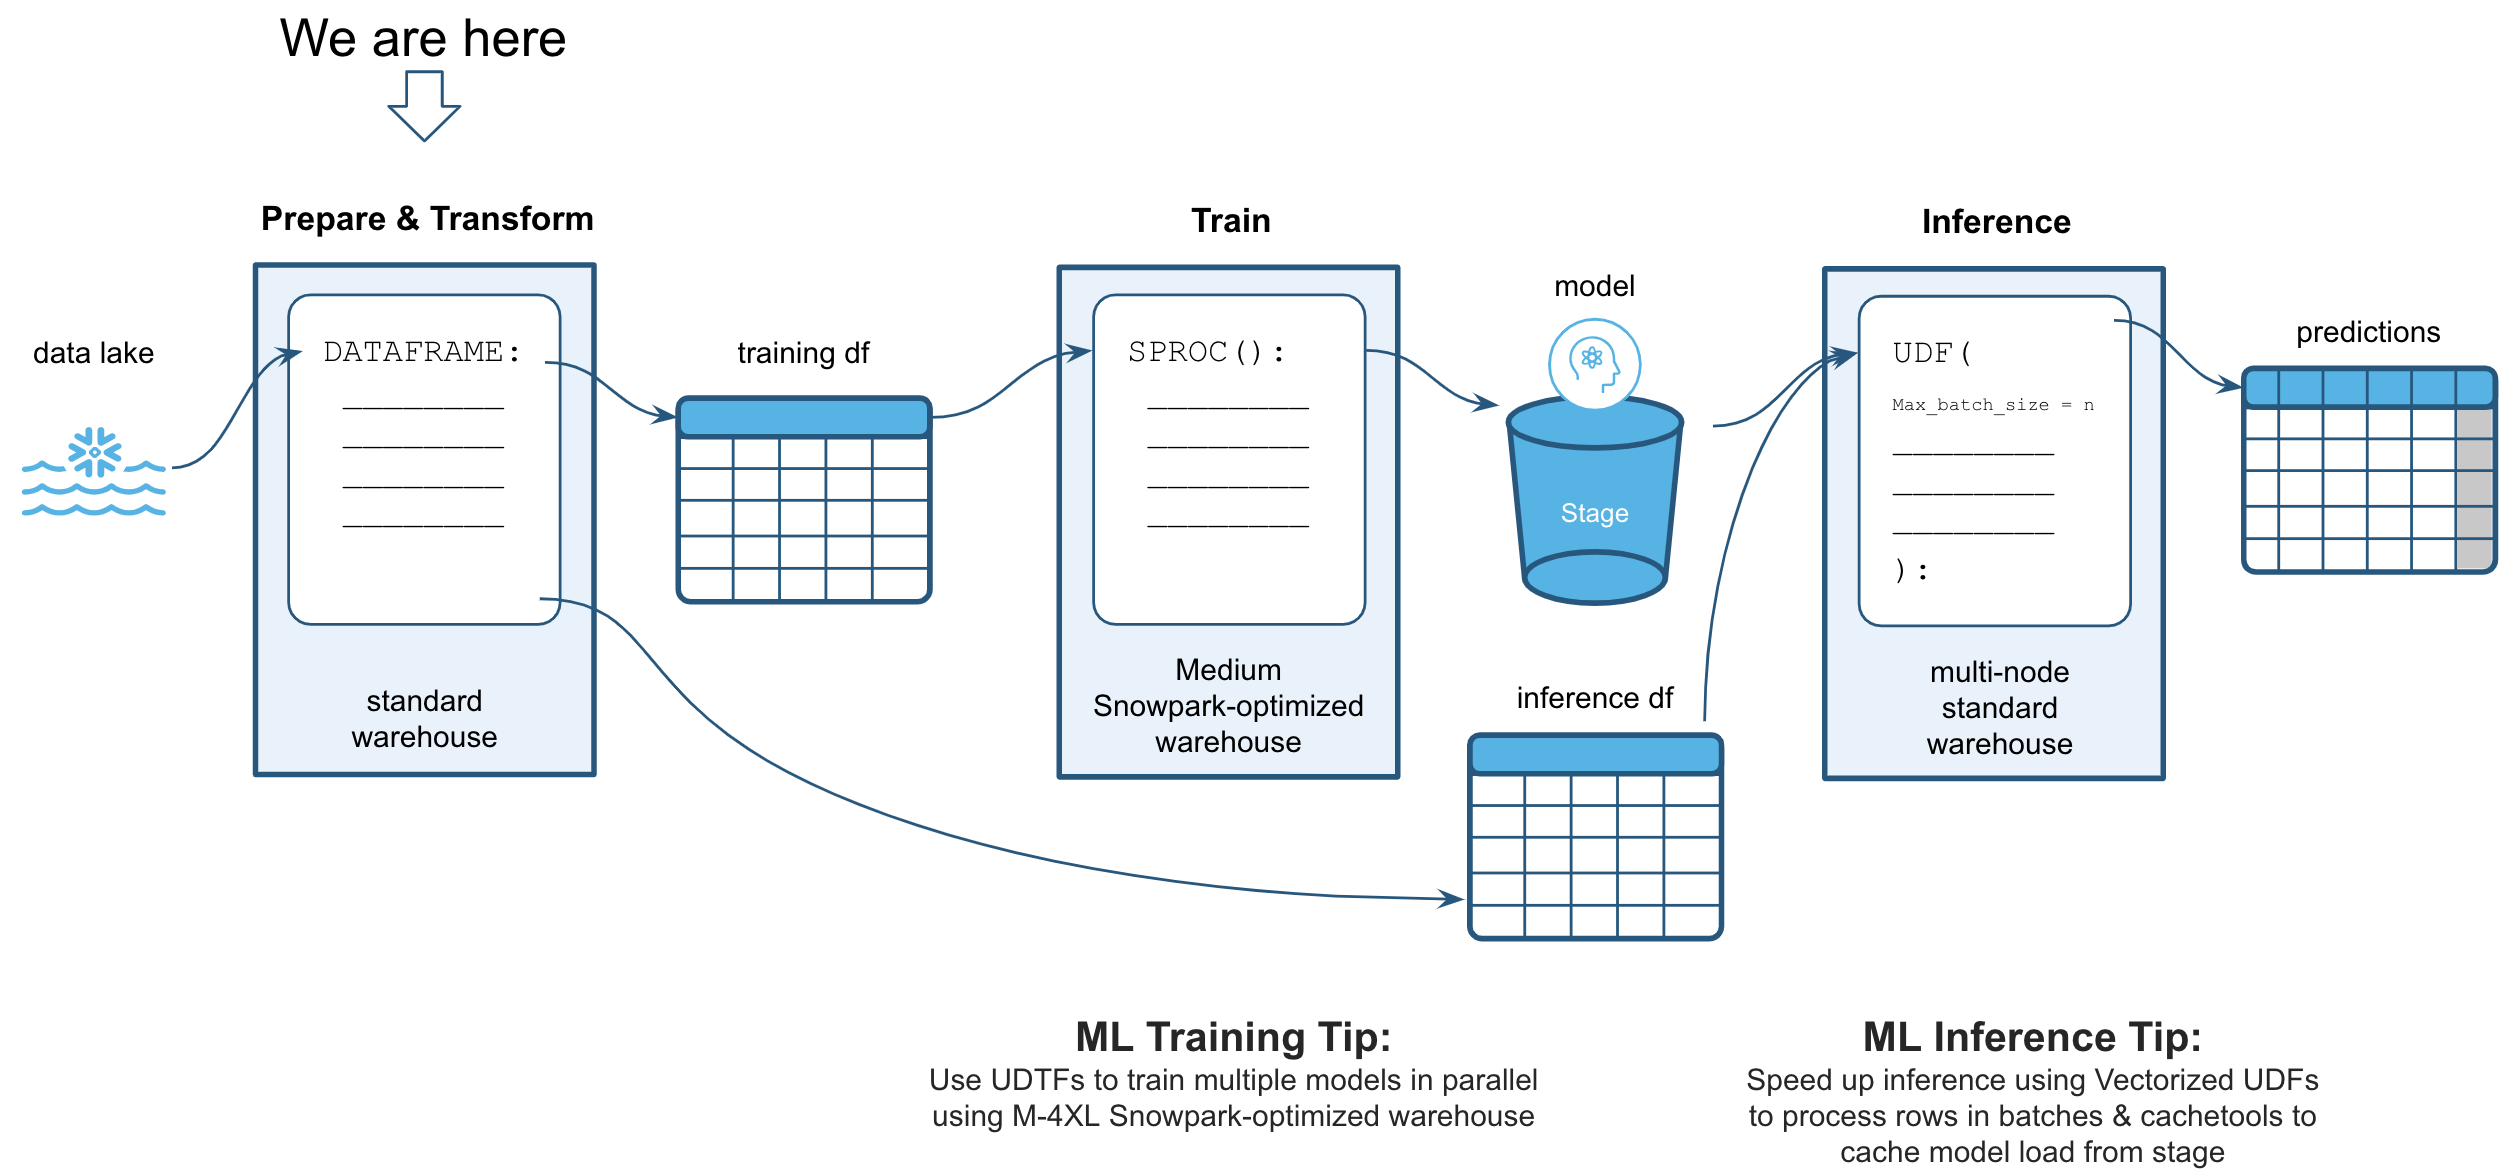

## Imports

In [1]:
import snowflake.snowpark as snowpark
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from snowflake.ml.modeling.preprocessing import *

import json
import pandas as pd
import matplotlib.pyplot as plt

Get installed versions of the libraries we will use later when deploying to Snowflake

In [2]:
with open('packages_version.json') as f:
    packages_version = json.load(f)

In [3]:
packages_version

{'snowflake-snowpark-python': '1.5.1',
 'pandas': '1.5.3',
 'scikit-learn': '1.2.2',
 'lightgbm': '3.3.5',
 'xgboost': '1.7.3',
 'joblib': '1.2.0',
 'imbalanced-learn': '0.10.1'}

## Create Snowpark Session

In [4]:
with open('creds.json') as f:
    connection_parameters = json.load(f)

In [5]:
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


## Explore and Prepare Data
We will use two tables, APPLICATION_RECORD and CREDIT_RECORD, for creating the data set needed for training our model.

In [6]:
# Creating a Snowpark DataFrame
application_record_sdf = session.table('APPLICATION_RECORD')
credit_record_sdf = session.table('CREDIT_RECORD')

Start with APPLICATION_RECORD

In [7]:
# How many records do we have?
application_record_sdf.count()

438557

### Duplicate Removal
Check if we have duplicated records in the ID column.

In [8]:
duplicates_sdf = application_record_sdf.group_by('ID').agg(F.count(('ID'))).filter(F.col('COUNT(ID)') > 1)
print('Number Duplicates:', duplicates_sdf.count())

Number Duplicates: 47


Use the **drop_duplicates** to remove duplicated rows

In [9]:
application_record_sdf = application_record_sdf.drop_duplicates('ID')
application_record_sdf.count()

438510

### Simple Statistics
Obtaining simple statistics per column - why are some statistics missing?  
Can you already identify problems in our data?  
For example count always return the number of non null records.  
**Hint:** ID variables are useless for ML models (but we need it for joining)  
**Hint:** Missing values for OCCUPATION_TYPE  
**Hint:** Max Value for DAYS_EMPLOYED seems wrong  

In [10]:
# application_record_sdf.describe().show()
application_record_sdf.describe().to_pandas()

,SUMMARY,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,mean,6.022035e+06,None,None,None,0.427381,1.875254e+05,None,None,None,None,-15998.022996,60566.188769,1.0,0.206128,0.287770,0.108200,None,2.194463
1,count,4.385100e+05,438510,438510,438510,438510.000000,4.385100e+05,438510,438510,438510,438510,438510.000000,438510.000000,438510.0,438510.000000,438510.000000,438510.000000,304317,438510.000000
2,stddev,5.714962e+05,None,None,None,0.724874,1.100893e+05,None,None,None,None,4185.016222,138770.072835,0.0,0.404523,0.452724,0.310633,None,0.897192
3,min,5.008804e+06,F,N,N,0.000000,2.610000e+04,Commercial associate,Academic degree,Civil marriage,Co-op apartment,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,Accountants,1.000000
4,max,7.999952e+06,M,Y,Y,19.000000,6.750000e+06,Working,Secondary / secondary special,Widow,With parents,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,Waiters/barmen staff,20.000000


### Missing Value Imputation
The describe output show that we have missing values in OCCUPATION_TYPE, it's count are less (304317) than the total count (438557)  
We will use the **fillna** method to replace missing values in OCCUPATION_TYPE with 'OTHER', since they are so many we creates a new category for it.

In [11]:
application_record_sdf = application_record_sdf.fillna(value='OTHER', subset=['OCCUPATION_TYPE'])
application_record_sdf.describe().show()
# application_record_sdf.describe().to_pandas()  # for better display format

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"ID"               |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"CNT_CHILDREN"      |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"    |"NAME_EDUCATION_TYPE"          |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"DAYS_BIRTH"       |"DAYS_EMPLOYED"     |"FLAG_MOBIL"  |"FLAG_WORK_PHONE"   |"FLAG_PHONE"         |"FLAG_EMAIL"        |"OCCUPATION_TYPE"     |"CNT_FAM_MEMBERS"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Finding constant variables
How many distinct values do we have per column?  
**Hint:** Constant values are probably irrelevant  
**Hint:** Variables with many different values can be problematic

In [12]:
unique_values = []
for column in application_record_sdf.columns:
    unique_values.append([column, application_record_sdf.select(column).distinct().count()])
pd.DataFrame(unique_values, columns=['COLUMN_NAME','NUM_UNIQUE_VALUES'])

,COLUMN_NAME,NUM_UNIQUE_VALUES
0,ID,438510
1,CODE_GENDER,2
2,FLAG_OWN_CAR,2
3,FLAG_OWN_REALTY,2
4,CNT_CHILDREN,12
5,AMT_INCOME_TOTAL,866
6,NAME_INCOME_TYPE,5
7,NAME_EDUCATION_TYPE,5
8,NAME_FAMILY_STATUS,5
9,NAME_HOUSING_TYPE,6


FLAG_MOBIL has only one value so it will not provide any value, so we will drop it from our dataframe.

In [13]:
application_record_sdf = application_record_sdf.drop('FLAG_MOBIL')

### Response Variable (Target)

The target variable (column) is in the credit_record_sdf, CREDIT_RECORD, DataFrame and we want to join it with our application_record_sdf dataFrame. Before doing that we will transform the target column.

The traget column, Status, has multiple values which has the following meanings:<br>
0: 1-29 days past due<br>
1: 30-59 days past due<br>
2: 60-89 days overdue<br>
3: 90-119 days overdue<br>
4: 120-149 days overdue<br>
5: Overdue or bad debts, write-offs for more than 150 days<br>
C: paid off that month<br>
X: No loan for the month<br>

In this case we are only intersted to flag customers as either high-risk or low-risk. We have defined that a customer is high-risk (1) if during any month they are late on payments by 60 days or more.<br>
All other customers are low-risk (0).

We start by checking how the distribution is among the diffrent status codes.

In [14]:
credit_record_sdf.group_by('STATUS').count().sort('STATUS').show()

----------------------
|"STATUS"  |"COUNT"  |
----------------------
|0         |383120   |
|1         |11090    |
|2         |868      |
|3         |320      |
|4         |223      |
|5         |1693     |
|C         |442031   |
|X         |209230   |
----------------------



We will create a new column, TARGET, that will have a 1 for high-risk and 0 for low-risk.

Since credit_record_sdf is on month level we will aggregate and count the number of late payments by customer, ID, and if they have at least one late payment we set TARGET to 1 otherwise to 0.

In [15]:
cpunt = credit_record_sdf.group_by('ID')\
                        .agg(F.sum(F.iff(F.col('STATUS').in_(['2', '3','4','5']), 1, 0)).as_("CNT_LATE"))\
                        .with_column('TARGET', F.when(F.col('CNT_LATE') > 0, 1).otherwise(0)).drop("CNT_LATE")

cpunt.show()

----------------------
|"ID"     |"TARGET"  |
----------------------
|5001711  |0         |
|5001712  |0         |
|5001713  |0         |
|5001714  |0         |
|5001715  |0         |
|5001717  |0         |
|5001718  |0         |
|5001719  |0         |
|5001720  |0         |
|5001723  |0         |
----------------------



Check the target distribution  
**Hint**: Highly imbalanced target variables can be problematic

In [16]:
cpunt.group_by('TARGET').agg(F.count('TARGET')).show()

------------------------------
|"TARGET"  |"COUNT(TARGET)"  |
------------------------------
|0         |45318            |
|1         |667              |
------------------------------



Join cpunt with application_record_sdf

In [17]:
application_record_sdf = application_record_sdf.join(cpunt, using_columns='ID', join_type='inner')

application_record_sdf.count()

36457

In [18]:
application_record_sdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ID"     |"CODE_GENDER"  |"FLAG_OWN_CAR"  |"FLAG_OWN_REALTY"  |"CNT_CHILDREN"  |"AMT_INCOME_TOTAL"  |"NAME_INCOME_TYPE"    |"NAME_EDUCATION_TYPE"          |"NAME_FAMILY_STATUS"  |"NAME_HOUSING_TYPE"  |"DAYS_BIRTH"  |"DAYS_EMPLOYED"  |"FLAG_WORK_PHONE"  |"FLAG_PHONE"  |"FLAG_EMAIL"  |"OCCUPATION_TYPE"      |"CNT_FAM_MEMBERS"  |"TARGET"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Feature Engineering
For many ML algorithms we need numeric data, so we'll encode our variables.<br>

We will apply the following techniques:  
| COLUMN              | TECHNIQUE                                              |
|---------------------|--------------------------------------------------------|
| FLAG_OWN_CAR        | OrdinalEncoder                                         |
| FLAG_OWN_REALTY     | OrdinalEncoder                                         |
| AMT_INCOME_TOTAL    | StandardScaler                                         |
| CODE_GENDER         | OneHotEncoder                                          |
| NAME_INCOME_TYPE    | OneHotEncoder                                          |
| NAME_EDUCATION_TYPE | OneHotEncoder                                          |
| NAME_FAMILY_STATUS  | OneHotEncoder                                          |
| NAME_HOUSING_TYPE   | OneHotEncoder                                          |
| CNT_CHILDREN        | Custom Categories + OneHotEncoder                      |
| CNT_FAM_MEMBERS     | Custom Categories + OneHotEncoder                      |
| OCCUPATION_TYPE     | Custom Categories + OneHotEncoder                      |
| DAYS_BIRTH          | Transform to Years + StandardScaler                    |
| DAYS_EMPLOYED       | Transform to Years + Drop Outlier + StandardScaler     |
| FLAG_WORK_PHONE     | Drop                                                   |
| FLAG_PHONE          | Drop                                                   |
| FLAG_EMAIL          | Drop                                                   |

### Children  
Before we decide how many categorise we want for children we check the distribution of the existing values, we also check the number of high-risk customers.

In [19]:
# High Risk Ratio for CNT_CHILDREN
var_analysis = application_record_sdf.group_by('CNT_CHILDREN')
var_analysis = var_analysis.agg([F.count('CNT_CHILDREN').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis.sort('CNT_CHILDREN').show()

------------------------------------------
|"CNT_CHILDREN"  |"COUNT"  |"HIGH_RISK"  |
------------------------------------------
|0               |25201    |431          |
|1               |7492     |120          |
|2               |3256     |52           |
|3               |419      |12           |
|4               |63       |1            |
|5               |20       |0            |
|7               |2        |0            |
|14              |3        |0            |
|19              |1        |0            |
------------------------------------------



Based on above we will create a new variable/column CNT_CHILDREN_IND with values 0, 1 or 2More and then drop the CNT_CHILDREN column form the dataframe.

In [20]:
application_record_sdf = application_record_sdf.with_column('CNT_CHILDREN_IND', 
                                                            F.iff(F.col('CNT_CHILDREN') >= 2, 
                                                                  '2More', 
                                                                  F.to_varchar(F.col('CNT_CHILDREN'))
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('CNT_CHILDREN')
application_record_sdf[['ID', 'CNT_CHILDREN_IND']].show()

--------------------------------
|"ID"     |"CNT_CHILDREN_IND"  |
--------------------------------
|5088857  |2More               |
|5115581  |0                   |
|5068783  |0                   |
|5137375  |1                   |
|5085814  |0                   |
|5150182  |0                   |
|5024092  |0                   |
|5088820  |0                   |
|5056032  |0                   |
|5028780  |0                   |
--------------------------------



### Family Members
We use the same approach as we did for number of children.

In [21]:
var_analysis = application_record_sdf.group_by('CNT_FAM_MEMBERS')
var_analysis = var_analysis.agg([F.count('CNT_FAM_MEMBERS').as_('COUNT'), 
                                 F.sum('TARGET').as_('HIGH_RISK')])
var_analysis.sort('CNT_FAM_MEMBERS').show()

# Creating a new variable CNT_FAM_MEMBERS_IND with values 0, 1, 2 or 3More
application_record_sdf = application_record_sdf.with_column('CNT_FAM_MEMBERS_IND', 
                                                            F.iff(F.col('CNT_FAM_MEMBERS') >= 3, 
                                                                  '3More', 
                                                                  F.to_varchar(F.col('CNT_FAM_MEMBERS'))
                                                                 )
                                                           )
application_record_sdf = application_record_sdf.drop('CNT_FAM_MEMBERS')

application_record_sdf[['ID', 'CNT_FAM_MEMBERS_IND']].show()

---------------------------------------------
|"CNT_FAM_MEMBERS"  |"COUNT"  |"HIGH_RISK"  |
---------------------------------------------
|1.0                |6987     |139          |
|2.0                |19463    |313          |
|3.0                |6421     |105          |
|4.0                |3106     |46           |
|5.0                |397      |12           |
|6.0                |58       |1            |
|7.0                |19       |0            |
|9.0                |2        |0            |
|15.0               |3        |0            |
|20.0               |1        |0            |
---------------------------------------------

-----------------------------------
|"ID"     |"CNT_FAM_MEMBERS_IND"  |
-----------------------------------
|5088857  |3More                  |
|5115581  |2                      |
|5068783  |1                      |
|5137375  |3More                  |
|5085814  |2                      |
|5150182  |2                      |
|5024092  |1                   

### Days Birth
The age variable is very cryptic and hard to interpret.  
Let's calculate the customer age in years.  

Explanation of DAYS_BIRTH Variable:  
Counts backwards from current day (0), -1 means yesterday


<Axes: title={'center': 'Age Distribution'}, xlabel='AGE'>

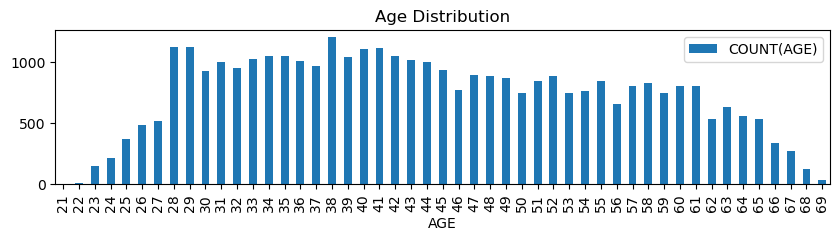

In [22]:
# Calculate the age given the number of days
application_record_sdf = application_record_sdf.with_column('AGE', F.abs(F.floor(F.col('DAYS_BIRTH') / 365)))
application_record_sdf = application_record_sdf.drop('DAYS_BIRTH')

# Age Distribution
grouped_ages_df = application_record_sdf.group_by('AGE').agg(F.count('AGE')).sort('AGE')
grouped_ages_df.to_pandas().plot.bar(x='AGE', y='COUNT(AGE)', figsize=(10,2), title='Age Distribution')

### Days Employment

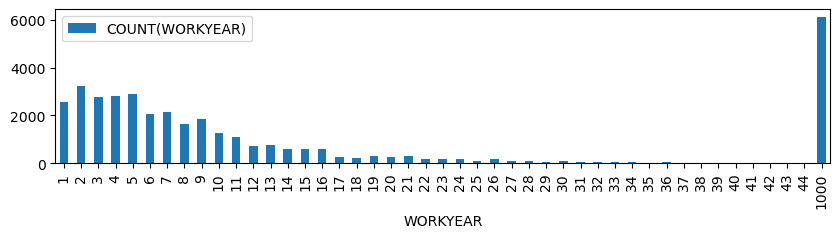

In [23]:
# Calculate the workyears given the number of days of employment
application_record_sdf = application_record_sdf.with_column('WORKYEAR', F.abs(F.floor(F.col('DAYS_EMPLOYED') / 365)))
application_record_sdf = application_record_sdf.drop('DAYS_EMPLOYED')
grouped_workyears_df = application_record_sdf.group_by('WORKYEAR').agg(F.count('WORKYEAR')).sort('WORKYEAR').to_pandas()
grouped_workyears_df.plot.bar(x='WORKYEAR', figsize=(10,2))

# Lets filter out people with 1000 years of employment ...
application_record_sdf = application_record_sdf.filter(F.col('WORKYEAR') < 50)

### Occupation
We do not need detailed level of occupation so we will group it into four diffrent categories, LABOURWORK, OFFICEWORK, HIGHTECHWORK and OTHER

In [24]:
var_analysis = application_record_sdf.group_by('OCCUPATION_TYPE').agg(F.count('OCCUPATION_TYPE').as_('COUNT'))
var_analysis = var_analysis.sort('COUNT').show()

# Occupation Type
labour_work = ['Cleaning staff', 
               'Cooking staff', 
               'Drivers', 
               'Laborers', 
               'Low-skill Laborers', 
               'Security staff', 
               'Waiters/barmen staff']

office_work = ['Accountants', 
               'Core staff', 
               'HR staff', 
               'Medicine staff', 
               'Private service staff', 
               'Realty agents', 
               'Sales staff', 
               'Secretaries']

hightech_work = ['Managers', 
                 'High skill tech staff', 
                 'IT staff']

application_record_sdf = application_record_sdf.with_column('OCCUPATION_TYPE', 
                                                            F.iff(F.col('OCCUPATION_TYPE').in_(labour_work), 'LABOURWORK', 
                                                                 F.iff(F.col('OCCUPATION_TYPE').in_(office_work), 'OFFICEWORK', 
                                                                      F.iff(F.col('OCCUPATION_TYPE').in_(hightech_work), 'HIGHTECHWORK', 'OTHER')
                                                                      )
                                                                 )
                                                           )
application_record_sdf[['OCCUPATION_TYPE']].show()

-----------------------------------
|"OCCUPATION_TYPE"      |"COUNT"  |
-----------------------------------
|IT staff               |60       |
|Realty agents          |79       |
|HR staff               |85       |
|Secretaries            |151      |
|Waiters/barmen staff   |174      |
|Low-skill Laborers     |175      |
|Private service staff  |344      |
|Cleaning staff         |551      |
|Security staff         |592      |
|Cooking staff          |655      |
-----------------------------------

---------------------
|"OCCUPATION_TYPE"  |
---------------------
|OTHER              |
|OTHER              |
|LABOURWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|OFFICEWORK         |
|LABOURWORK         |
|LABOURWORK         |
|LABOURWORK         |
---------------------



## SnowML Preprocessing

In [25]:
application_record_sdf = application_record_sdf.drop(['FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL'])

In [26]:
oe_cols = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

my_oe_encoder = OrdinalEncoder(input_cols=oe_cols, output_cols=oe_cols)
my_oe_encoder.fit(application_record_sdf)
application_record_sdf = my_oe_encoder.transform(application_record_sdf)

In [27]:
# Prepare values for One-Hot-Encoding
ohe_cols = ['CODE_GENDER','NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'CNT_CHILDREN_IND', 'CNT_FAM_MEMBERS_IND', 'OCCUPATION_TYPE','NAME_HOUSING_TYPE']

def fix_values(columnn):
    return F.upper(F.regexp_replace(F.col(columnn), '[^a-zA-Z0-9]+', '_'))

for col in ohe_cols:
    application_record_sdf = application_record_sdf.with_column(col, fix_values(col))

my_ohe_encoder = OneHotEncoder(input_cols=ohe_cols, output_cols=ohe_cols, drop_input_cols=True)
my_ohe_encoder.fit(application_record_sdf)
application_record_sdf = my_ohe_encoder.transform(application_record_sdf)

/Users/oazarmanesh/anaconda3/envs/pysnowpark/lib/python3.8/site-packages/snowflake/snowpark/session.py:1383: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(
/Users/oazarmanesh/anaconda3/envs/pysnowpark/lib/python3.8/site-packages/snowflake/snowpark/session.py:1383: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


In [28]:
scaler_cols = ['AMT_INCOME_TOTAL', 'AGE', 'WORKYEAR']

my_scaler = StandardScaler(input_cols=scaler_cols, output_cols=scaler_cols)
my_scaler.fit(application_record_sdf)
application_record_sdf = my_scaler.transform(application_record_sdf)

In [29]:
application_record_sdf.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
application_record_sdf.limit(10).to_pandas()

,AMT_INCOME_TOTAL,AGE,WORKYEAR,CODE_GENDER_F,CODE_GENDER_M,NAME_INCOME_TYPE_COMMERCIAL_ASSOCIATE,NAME_INCOME_TYPE_PENSIONER,NAME_INCOME_TYPE_STATE_SERVANT,NAME_INCOME_TYPE_STUDENT,NAME_INCOME_TYPE_WORKING,...,NAME_HOUSING_TYPE_CO_OP_APARTMENT,NAME_HOUSING_TYPE_HOUSE_APARTMENT,NAME_HOUSING_TYPE_MUNICIPAL_APARTMENT,NAME_HOUSING_TYPE_OFFICE_APARTMENT,NAME_HOUSING_TYPE_RENTED_APARTMENT,NAME_HOUSING_TYPE_WITH_PARENTS,FLAG_OWN_CAR,FLAG_OWN_REALTY,ID,TARGET
0,0.723608,1.244158,0.193361,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5008810,0
1,-0.783777,1.660495,0.811816,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008844,0
2,-0.783777,1.660495,0.811816,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008849,0
3,-0.654573,-0.629355,-0.425093,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5008873,0
4,0.723608,-0.629355,-0.579707,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,5008837,0
5,-0.654573,-0.629355,-0.425093,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5008880,0
6,0.508267,0.619654,-0.579707,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5008888,0
7,0.508267,0.619654,-0.579707,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5008889,0
8,0.982017,0.203318,0.193361,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5008909,0
9,0.982017,0.203318,0.193361,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,5008915,0


We can now save the transformed data into a new table

In [31]:
application_record_sdf.write.save_as_table(table_name='CREDIT_RISK_PREPARED', mode='overwrite')

# Synthetic Minority Oversampling Technique (SMOTE)
https://github.com/scikit-learn-contrib/imbalanced-learn

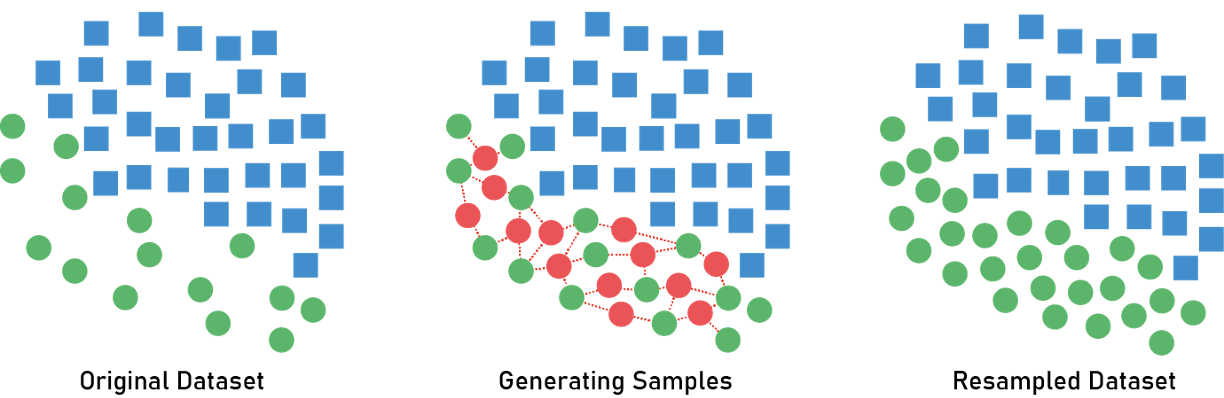

In [32]:
# We have highly imbalanced data
application_record_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|1         |503      |
|0         |29819    |
----------------------



Instead of pulling back the data localy we will create a Python Stored Procedure to do the sampling using the compute in Snowflake and save the result into a new table.

In order to create a Python Stored Procedure we need to create a Snowflake internal stage.

In [33]:
session.sql('CREATE OR REPLACE STAGE ML_PROCS').collect()
pd.DataFrame(session.sql('SHOW STAGES').collect())

,created_on,name,database_name,schema_name,url,has_credentials,has_encryption_key,owner,comment,region,type,cloud,notification_channel,storage_integration,owner_role_type
0,2023-08-16 10:35:54.364000-07:00,ML_PROCS,HOL_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL,None,None,None,ROLE
1,2023-08-16 10:35:37.919000-07:00,nnycqaafpy,HOL_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL TEMPORARY,None,None,None,ROLE
2,2023-08-16 10:35:31.311000-07:00,ogozsusnsx,HOL_DB,PUBLIC,,N,N,ACCOUNTADMIN,,None,INTERNAL TEMPORARY,None,None,None,ROLE


In [34]:
# This local Python-function will be registered as a Stored Procedure and runs in Snowflake
def sproc_oversample_smote(session: Session, 
                           training_table: str, 
                           feature_cols: list,
                           target_col: str,
                           target_table: str) -> T.Variant:
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]
    
    # Oversample minority class via SMOTE
    from imblearn.over_sampling import SMOTE
    X_balance, y_balance = SMOTE().fit_resample(X,y)
    
    # Combine return values into single pandas dataframe
    X_balance[target_col] = y_balance
    
    # Persist dataframe in Snowflake table
    session.sql('DROP TABLE IF EXISTS {}'.format(target_table)).collect()
    session.write_pandas(X_balance, table_name=target_table, auto_create_table=True)
    
    # Getting model coefficients
    return "Successfully oversampled"

Registering the function as a Stored Procedure. By pinning the version numbers of the the third-party python packages we makes sure that we use the same version in Snowflake as we have installed locally, otherwise the latest version avalible in the Anaconda Snowflake channel will be used

In [35]:
sproc_oversample_smote = session.sproc.register(func=sproc_oversample_smote, 
                                                name='sproc_oversample_smote', 
                                                is_permanent=True, 
                                                replace=True,
                                                stage_location='@ML_PROCS',
                                                packages=[f'snowflake-snowpark-python=={packages_version["snowflake-snowpark-python"]}',
                                                          f'scikit-learn=={packages_version["scikit-learn"]}',
                                                          f'imbalanced-learn==0.10.1'])

In [36]:
training_table = 'CREDIT_RISK_PREPARED'
# get feature columns
feature_cols = application_record_sdf.columns
feature_cols.remove('TARGET')
target_col = 'TARGET'
target_table = 'CREDIT_RISK_PREPARED_BALANCED'

sproc_oversample_smote(
    training_table, 
    feature_cols, 
    target_col,
    target_table, 
    session=session
    )

'"Successfully oversampled"'

In [37]:
# Now our training data is balanced
train_data_sdf = session.table('CREDIT_RISK_PREPARED_BALANCED')
train_data_sdf.group_by('TARGET').count().show()

----------------------
|"TARGET"  |"COUNT"  |
----------------------
|0         |29819    |
|1         |29819    |
----------------------



In [38]:
session.close()